# HW Юлия Терентьева, АДБМ-19

In [2]:
!pip install bcbio-gff
!pip install biopython

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from BCBio import GFF

In [6]:
expressions = pd.read_csv('01. RiboSeq_RNASeq_HCC_counts.tsv',sep = '\t', index_col = 1)
expressions.head()

,geneID,LC001-normal-RPF,LC001-tumor-RPF,LC001-normal-RNA,LC001-tumor-RNA,LC033-normal-RPF,LC033-tumor-RPF,LC033-normal-RNA,LC033-tumor-RNA,LC034-normal-RPF,LC034-tumor-RPF,LC034-normal-RNA,LC034-tumor-RNA,LC501-normal-RPF,LC501-tumor-RPF,LC501-normal-RNA,LC501-tumor-RNA,LC502-normal-RPF,LC502-tumor-RPF,LC502-normal-RNA,LC502-tumor-RNA,LC505-normal-RPF,LC505-tumor-RPF,LC505-normal-RNA,LC505-tumor-RNA,LC506-normal-RPF,LC506-tumor-RPF,LC506-normal-RNA,LC506-tumor-RNA,LC507-normal-RPF,LC507-tumor-RPF,LC507-normal-RNA,LC507-tumor-RNA,LC508-normal-RPF,LC508-tumor-RPF,LC508-normal-RNA,LC508-tumor-RNA,LC509-normal-RPF,LC509-tumor-RPF,LC509-normal-RNA,LC509-tumor-RNA
geneSymbol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TSPAN6,ENSG00000000003.14,0,0,402,873,0,0,301,1627,0,0,258,65,0,0,226,353,0,0,208,399,0,0,153,361,0,0,157,333,0,0,218,457,0,0,200,889,0,0,161,857.0
TNMD,ENSG00000000005.5,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,NaN
DPM1,ENSG00000000419.12,168,239,88,187,114,439,66,201,325,117,80,16,106,192,54,165,118,292,57,174,159,237,61,155,149,230,104,114,169,260,92,170,109,357,60,244,141,173,56,83.0
SCYL3,ENSG00000000457.13,65,121,60,106,36,163,70,156,130,76,77,67,34,43,78,68,84,221,97,128,74,185,76,185,65,98,114,74,81,105,127,176,67,176,55,261,64,100,68,176.0
C1orf112,ENSG00000000460.16,8,43,18,70,16,76,4,63,44,14,60,4,5,27,17,112,24,42,28,14,10,71,8,118,18,103,25,98,79,225,124,437,7,167,34,201,6,61,9,58.0


In [7]:
del expressions['geneID']

In [8]:
expressions.head()

,LC001-normal-RPF,LC001-tumor-RPF,LC001-normal-RNA,LC001-tumor-RNA,LC033-normal-RPF,LC033-tumor-RPF,LC033-normal-RNA,LC033-tumor-RNA,LC034-normal-RPF,LC034-tumor-RPF,LC034-normal-RNA,LC034-tumor-RNA,LC501-normal-RPF,LC501-tumor-RPF,LC501-normal-RNA,LC501-tumor-RNA,LC502-normal-RPF,LC502-tumor-RPF,LC502-normal-RNA,LC502-tumor-RNA,LC505-normal-RPF,LC505-tumor-RPF,LC505-normal-RNA,LC505-tumor-RNA,LC506-normal-RPF,LC506-tumor-RPF,LC506-normal-RNA,LC506-tumor-RNA,LC507-normal-RPF,LC507-tumor-RPF,LC507-normal-RNA,LC507-tumor-RNA,LC508-normal-RPF,LC508-tumor-RPF,LC508-normal-RNA,LC508-tumor-RNA,LC509-normal-RPF,LC509-tumor-RPF,LC509-normal-RNA,LC509-tumor-RNA
geneSymbol,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TSPAN6,0,0,402,873,0,0,301,1627,0,0,258,65,0,0,226,353,0,0,208,399,0,0,153,361,0,0,157,333,0,0,218,457,0,0,200,889,0,0,161,857.0
TNMD,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,NaN
DPM1,168,239,88,187,114,439,66,201,325,117,80,16,106,192,54,165,118,292,57,174,159,237,61,155,149,230,104,114,169,260,92,170,109,357,60,244,141,173,56,83.0
SCYL3,65,121,60,106,36,163,70,156,130,76,77,67,34,43,78,68,84,221,97,128,74,185,76,185,65,98,114,74,81,105,127,176,67,176,55,261,64,100,68,176.0
C1orf112,8,43,18,70,16,76,4,63,44,14,60,4,5,27,17,112,24,42,28,14,10,71,8,118,18,103,25,98,79,225,124,437,7,167,34,201,6,61,9,58.0


In [9]:
expressions_RNA = expressions.T[expressions.columns.str.endswith('RNA')].T
expressions_RPF = expressions.T[expressions.columns.str.endswith('RPF')].T

# Задание 1.
1. Для каждого гена найдите коэффициент корреляции числа каунтов между
экспериментами RNA-Seq и Ribo-Seq. Какую корреляцию вы выберете — Пирсона или Спирмена? Обратите внимание, что перед вами не нормированные каунты. 

Рассчитаем коэффициент корреляции Спирмена:

In [8]:
corr_RNA_RPF = []
for i in range(0, expressions_RNA.shape[0]):
  current_corr = pd.DataFrame(expressions_RNA.iloc[i].values).corrwith(pd.DataFrame(expressions_RPF.iloc[i].values), axis = 0, method = 'spearman')
  corr_RNA_RPF.append(current_corr)

In [9]:
corr_RNA_RPF = pd.DataFrame(corr_RNA_RPF)

In [10]:
df = pd.DataFrame(expressions_RNA.index.values)

In [11]:
df['Corr'] = corr_RNA_RPF

In [12]:
df.rename(columns = {0:'geneSymbol'})

,geneSymbol,Corr
0,TSPAN6,NaN
1,TNMD,-0.147807
2,DPM1,0.849624
3,SCYL3,0.697779
4,C1orf112,0.811583
...,...,...
18940,RP1-34B20.21,0.382301
18941,RP11-511P7.5,0.191364
18942,KLF18,NaN
18943,TRBV6-2,NaN


Далее удалим гены, у которых значения корреляции получились NaN. Это верно, например, для следующих генов: KLF18 (регулирует транскрипцию РНК-полимеразы II) и TRBV6-2	(рецептор Т клеток, экспрессируется в тимусе) - маловероятно, чтобы они экспрессировались в печени.

2. Постройте гистограмму распределения этих коэффициентов корреляции. Для каких генов корреляция самая высокая, а для каких — самая низкая? Как вы можете это объяснить?

Построим гистограмму коэффициентов корреляции:

In [13]:
df.dropna(inplace=True)

In [14]:
len(df)

16849

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


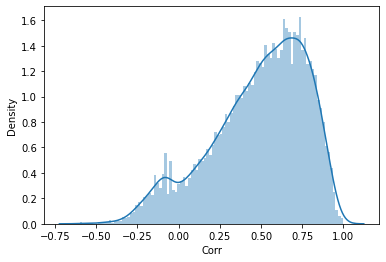

In [15]:
sns.distplot(df['Corr'], bins = 100)

Гены с самой высокой корреляцией

In [16]:
df[abs(df['Corr']) >= 0.98]

,0,Corr
4534,PRG4,0.990977
5495,SCGB1D2,1.000000
8121,KCNA10,1.000000
9747,HKDC1,0.980053
9754,PRG3,1.000000
11889,CYP7A1,0.980820
12719,LGALS4,0.981942
13158,FAM46D,1.000000
13477,TMPRSS7,1.000000
13578,MAGEB6,1.000000


Гены с самой низкой корреляцией

In [17]:
df[abs(df['Corr']) <= 0.01]

,0,Corr
133,KDM7A,0.006396
155,MYH13,0.000000
310,PRICKLE3,-0.006795
450,KCNG1,0.000000
555,PNKP,0.003387
...,...,...
18270,SALL3,0.000000
18595,GPR75-ASB3,0.004293
18659,RP11-475E11.9,0.009879
18776,NEFL,0.000000


Думаю, что RNA-seq и Ribo-seq детектировали гены, которые отвечают за окислительно-восстановительные процессы, а гены, которые не влияют на изменение уровня белка, не оказались значимыми в Ribo-seq.

3. Найдите дифференциально экспрессированные гены по RNA-Seq между нормой и
опухолью. Для этого можете использовать DESeq2 или edgeR (для DESeq есть обёртка на Python). Постройте volcano plot. То же самое сделайте и для Ribo-Seq эксперимента. Совпадают ли результаты дифференциальной экспрессии? Какие гены оказались значимо различны по экспрессии в одном случае, а какие — в другом? Выводы подкрепите графиками.

Выполнила на R (см. DE_RNAseq.R).

# Задание 2 . Анализ wig-файла
1. Присутствует ли в покрытии генома неравномерность? Рассмотрите неравномерность покрытия на примере любого выбранного вами гена. Что вы можете сказать про эту неравномерность? Присутствует ли там периодичность в три нуклеотида? А если взять среднее по большому количеству генов (взяв за точку отсчёта старт-кодон)? Выводы проиллюстрируйте графиками.

In [4]:
def parser(file, gsize):
  counts = np.zeros(gsize)
  with open(file, 'r') as file:
    for line in file:
      data = line.split()
      pos, count = int(data[0]), int(data[1])
      pos = pos - 2
      counts[pos] = count
    return counts

forward = parser('02. RiboSeq_EColi_track_f.wig', 4641668)
reverse = parser('02. RiboSeq_EColi_track_r.wig', 4641668)

In [5]:
genbank_filename = "sequence.gff3"
genbank_file = open(genbank_filename)
records = list(GFF.parse(genbank_file, limit_info={"gff_type": ["CDS"]}))
genbank_file.close()
record = records[0]

In [6]:
features = []
for feature in record.features:
  if feature.type == "CDS":
    features.append(feature)
coverage_size = 120 # рассмотрим покрытие 120 нуклеотидов, тк на отдельном гене через IGV будет неинформативно
gene_counts = {}
pos_counts = np.zeros(coverage_size, dtype=np.float64)
for feature in features:
  if feature.location.strand > 0:
    counts = forward
  else:
    counts = reverse
  start, end = feature.location.nofuzzy_start, feature.location.nofuzzy_end
  length = end - start
  if length % 3 != 0:
    raise Exception("Length is not devided by 3") 
  gene_counts[feature.id] = counts[start:end].sum()
  if length >= pos_counts.size:
      s, e = start, start + pos_counts.size
      pos_counts[:] = pos_counts[:] + counts[s:e]
      

Text(0.5, 0, 'position')

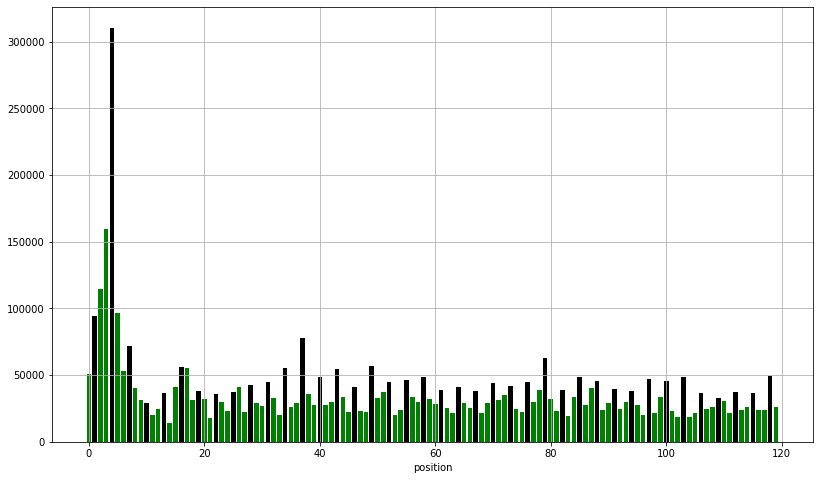

In [7]:
position = np.arange(pos_counts.size)
color = ['black' if i % 3 == 1 else 'green' for i in position]
fig = plt.figure(figsize = (30,8));
ax = fig.add_subplot(121);
xticks = np.arange(pos_counts.size, step=6);
ax.bar(position, pos_counts, color = color);
ax.grid();
ax.set_xlabel("position")

В принципе, периодичность в 3 нуклеотида видна (где-то после 30 нуклеотида), то есть каждый 3-й чёрный пик выше, чем зелёный. 

Также самый высокий пик сдвинут и находится не в первом кодоне, что несколько странно.


2. Рассчитайте значения RPKM и TPM для каждого гена. В чём разница между RPKM и TPM? Для чего используется каждая метрика?

RPKM - количество чтений на миллион килобаз

TPM - количество транскриптов на миллион килобаз

---

Эти метрики используюся для нормализации глубины секвенирования и длины гена.

In [13]:
RPKM = {}
TPM = {}
library_size = sum(gene_counts.values())
for feature in features:
    start, end = feature.location.nofuzzy_start, feature.location.nofuzzy_end
    length = end - start
    if length % 3 != 0:
      raise Exception("Length of feature is not devided by 3") 
    RPKM[feature.id] = gene_counts[feature.id] * 10**9 / (library_size * length)
    TPM[feature.id] = gene_counts[feature.id] * 10**6 / length
    sum_val = sum(TPM.values())
    TPM[feature.id] = TPM[feature.id] / sum_val

3. Проанализируйте значения RPKM для генов из оперона ATP. Укажите геномные
координаты оперона, а также то, какие гены в него входят. Есть ли разница между RPKM у различных генов, присутствующих в опероне? Как вы можете объяснить эту разницу с биологической точки зрения? Как вы думаете, можно ли оценить эту разницу при помощи классического RNA-Seq?

In [25]:
ATP = []
for feature in features:
  if "ATP synthase" in feature.qualifiers["product"][0]:
    ATP.append(feature) 
for f in ATP:
    print(f"id: {f.id}" + f"\tloc:{f.location}" + f"\tproduct: {f.qualifiers['product']}")

id: cds-AAC75008.1	loc:[2016553:2017927](+)	product: ['flagellum-specific ATP synthase FliI']
id: cds-AAC76754.1	loc:[3915552:3915972](-)	product: ['ATP synthase F1 complex subunit epsilon']
id: cds-AAC76755.1	loc:[3915992:3917375](-)	product: ['ATP synthase F1 complex subunit beta']
id: cds-AAC76756.1	loc:[3917401:3918265](-)	product: ['ATP synthase F1 complex subunit gamma']
id: cds-AAC76757.1	loc:[3918315:3919857](-)	product: ['ATP synthase F1 complex subunit alpha']
id: cds-AAC76758.1	loc:[3919869:3920403](-)	product: ['ATP synthase F1 complex subunit delta']
id: cds-AAC76759.1	loc:[3920417:3920888](-)	product: ['ATP synthase Fo complex subunit b']
id: cds-AAC76760.1	loc:[3920949:3921189](-)	product: ['ATP synthase Fo complex subunit c']
id: cds-AAC76761.1	loc:[3921235:3922051](-)	product: ['ATP synthase Fo complex subunit a']
id: cds-AAC76762.2	loc:[3922059:3922440](-)	product: ['ATP synthase accessory factor AtpI']


In [26]:
atp = ATP[1:]
for gene in atp:
    print(gene.qualifiers['product'][0] + " RPKM: " + str(RPKM[gene.id]))

ATP synthase F1 complex subunit epsilon RPKM: 1141.25772518656
ATP synthase F1 complex subunit beta RPKM: 2526.824167189789
ATP synthase F1 complex subunit gamma RPKM: 604.8768401142592
ATP synthase F1 complex subunit alpha RPKM: 1964.8294829509189
ATP synthase F1 complex subunit delta RPKM: 725.7274527231382
ATP synthase Fo complex subunit b RPKM: 1130.6014870617732
ATP synthase Fo complex subunit c RPKM: 12346.851339760828
ATP synthase Fo complex subunit a RPKM: 1162.489084653384
ATP synthase accessory factor AtpI RPKM: 55.119793183752


Здесь http://www.atpsynthase.info/FAQ.html я нашла понятное биологическое объяснение: расссмотрим ATP synthase Fo, которая содержит субъединицы  a (1), b (2) и c (10-15). Видна разница RPKM для различных субъединиц - у a и b практически одинаковое значение, у c - в ~10 раз больше. То есть Ribo-seq может рассматривать отдельно субъединицы рибосомы. Однако при помощи RNA-seq такие результаты мы бы не получили, потому что у прокариот считывался бы весь оперон (оперон ~ транскрипт). Поэтому при делении на длину оперона не получилось бы идентифицировать отдельные транскрипты, риды были бы равномерно распределены по всей длине.